# Introduction:
This project aims to predict basketball player performance using statistical features like points, assists, and rebounds.

we built a predictive model to estimate future performance, initially Linear Regression and then Ridge Regression to improve Accuracy.

**Linear Regression** is a fundamental statistical method used to model the relationship between a dependent variable (target) and one or more independent variables (features) by fitting a linear equation to the observed data.

**Ridge Regression** is a type of linear regression that introduces regularization to the model by adding a penalty term to the cost function.

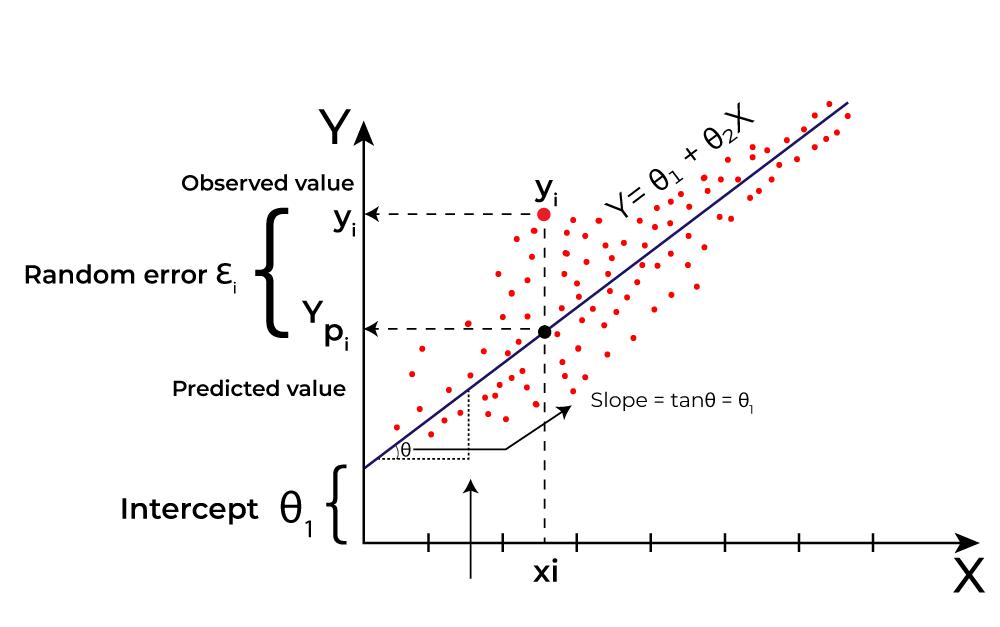

# Libraries


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

# Loading Data

In [6]:
data = pd.read_csv('all_seasons.csv')
data.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,42,64,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,34,4,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,12,41,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,7,64,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,22,52,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97


# EDA

In [8]:
print(data.isnull().sum())

Unnamed: 0           0
player_name          0
team_abbreviation    0
age                  0
player_height        0
player_weight        0
college              0
country              0
draft_year           0
draft_round          0
draft_number         0
gp                   0
pts                  0
reb                  0
ast                  0
net_rating           0
oreb_pct             0
dreb_pct             0
usg_pct              0
ts_pct               0
ast_pct              0
season               0
dtype: int64


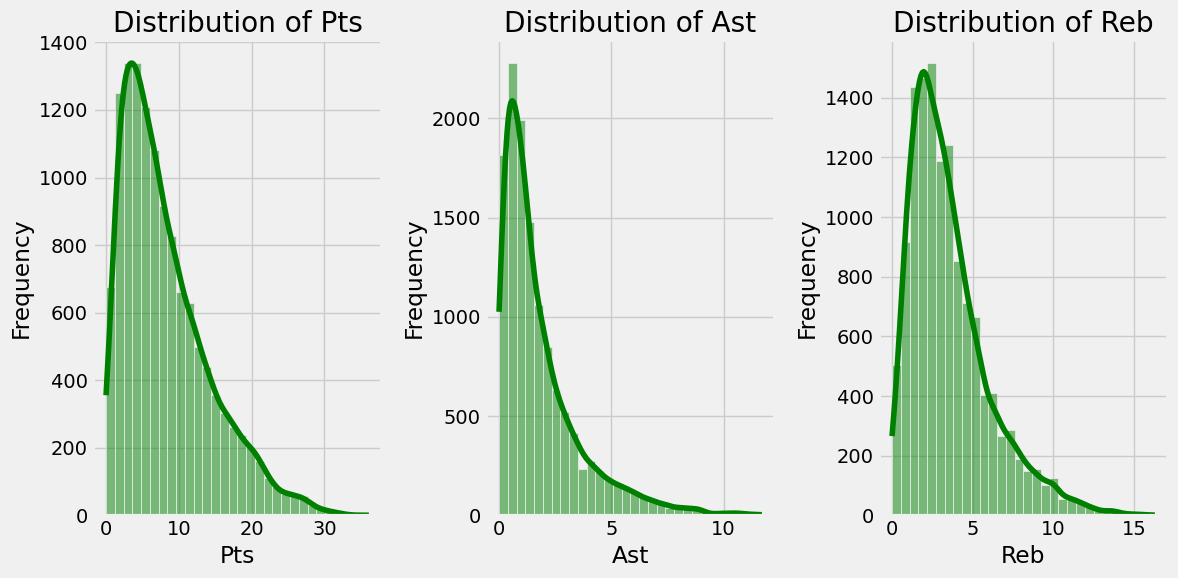

In [10]:
# Select key statistics for analysis
key_stats = ['pts', 'ast', 'reb']

# 1. Visualize distributions
plt.figure(figsize=(12, 6))
for i, stat in enumerate(key_stats):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[stat], kde=True, bins=30, color='green')
    plt.title(f"Distribution of {stat.capitalize()}")
    plt.xlabel(stat.capitalize())
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()



The graphs indicate that a majority of players perform within a lower range for each statistic, with only a few players excelling in scoring, assists, and rebounds, resulting in a long tail for higher values. This suggests a trend where a small number of players may dominate these statistics.

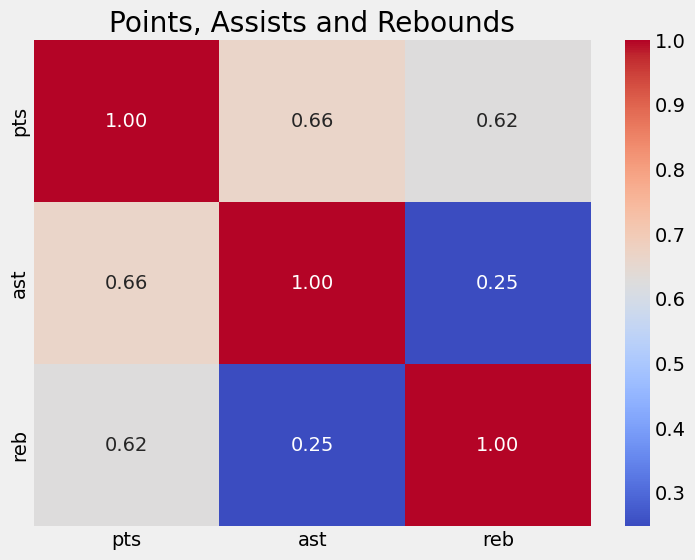

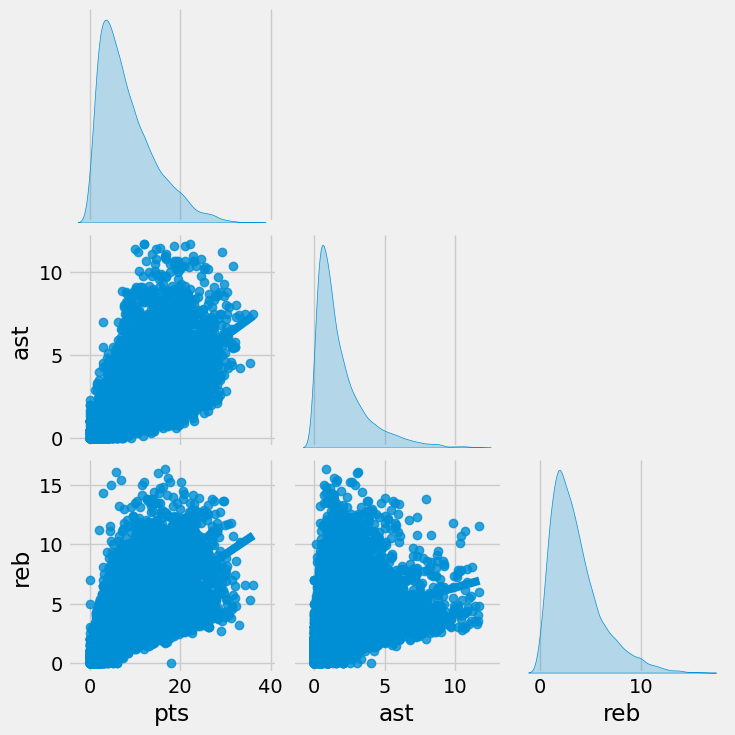

In [30]:
# 2. Visualize correlations
correlation_matrix = data[key_stats].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Points, Assists and Rebounds")
plt.show()

# 3. Pairplot for deeper analysis
sns.pairplot(data[key_stats], kind="reg", diag_kind="kde", corner=True)
plt.show()

The graph suggests that while scoring and assists are closely linked in performance, assists are less correlated with rebounding. This insight could be useful for coaching strategies, player development, and understanding player roles on a team. It highlights how a player’s capacity in scoring may influence their overall contributions on the court, while assists appears more independent of rebounding ability.

# Cummulative points

In [16]:
def create_cumulative_features(dataset, player_col, stat_col):

    dataset = dataset.sort_values(by=[player_col, 'season'])
    dataset[f'{stat_col}_cumulative'] = dataset.groupby(player_col)[stat_col].cumsum()
    
    return dataset

# Example usage for creating cumulative points feature
data_with_cumulative = create_cumulative_features(data, player_col='player_name', stat_col='pts')

# Preview the result
print(data_with_cumulative[['player_name', 'season', 'pts', 'pts_cumulative']].head())


     player_name   season  pts  pts_cumulative
419   A.C. Green  1996-97  7.2             7.2
667   A.C. Green  1997-98  7.3            14.5
1006  A.C. Green  1998-99  4.9            19.4
1626  A.C. Green  1999-00  5.0            24.4
1971  A.C. Green  2000-01  4.5            28.9


# Standarization

In [24]:
# Drop non-numeric columns (e.g., 'player_name', 'team_abbreviation')
data_numeric = data.select_dtypes(include=['number'])

# Function to standardize the whole dataset
def standardize_whole_data(df):
    # Initialize StandardScaler
    scaler = StandardScaler()
    
    # Standardize the entire dataset
    df_standardized = scaler.fit_transform(df)
    
    # Convert the result back into a DataFrame with the same column names
    df_standardized = pd.DataFrame(df_standardized, columns=df.columns)
    
    return df_standardized


data_standardized = standardize_whole_data(data_numeric)

# Check the first few rows of the standardized data
print(data_standardized.head())

   Unnamed: 0       age  player_height  player_weight        gp       pts  \
0   -1.731916 -1.162771      -0.824862      -0.439601  0.512114 -0.716812   
1   -1.731646  0.220023      -1.103654      -1.133159 -1.879855 -0.733433   
2   -1.731377 -0.240909       0.290306       0.253956 -0.404807  0.014530   
3   -1.731107  0.680954       0.290306       0.144447  0.512114  0.330337   
4   -1.730837 -0.932306       1.405474       1.568066  0.033720 -0.899647   

        reb       ast  net_rating  oreb_pct  dreb_pct   usg_pct    ts_pct  \
0 -0.830776  0.319485    0.199480 -0.278612 -1.114141 -0.292117 -0.256963   
1 -0.911493 -0.846683    0.878536 -0.555537 -0.474253 -0.198734 -0.158654   
2  1.146794  0.041826   -0.471681  1.198321  0.709540 -0.180057 -0.011191   
3 -0.306114 -0.069237   -0.037400 -0.624768 -0.474253  0.398919  0.136272   
4 -0.750059 -0.846683   -0.937545  1.106012  0.453585  0.193476 -0.129162   

    ast_pct  
0  1.236138  
1 -0.940819  
2 -0.070036  
3 -0.070036  
4 -0

# Points Vs Assists
Just to see the relationship of two variables, as well as we can take other variables also!

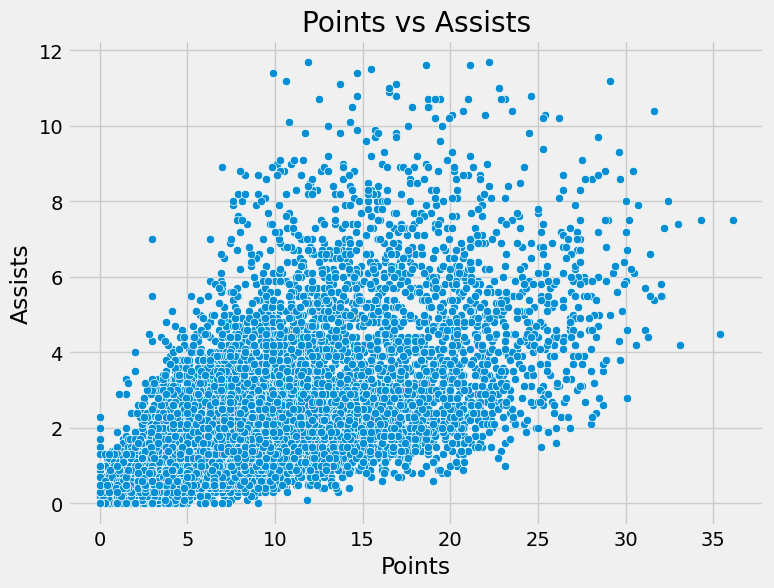

In [29]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=data['pts'], y=data['ast'])
plt.title('Points vs Assists')
plt.xlabel('Points')
plt.ylabel('Assists')
plt.show()

Points and Assisting are related, highlighting that effective Points often accompanies playmaking.


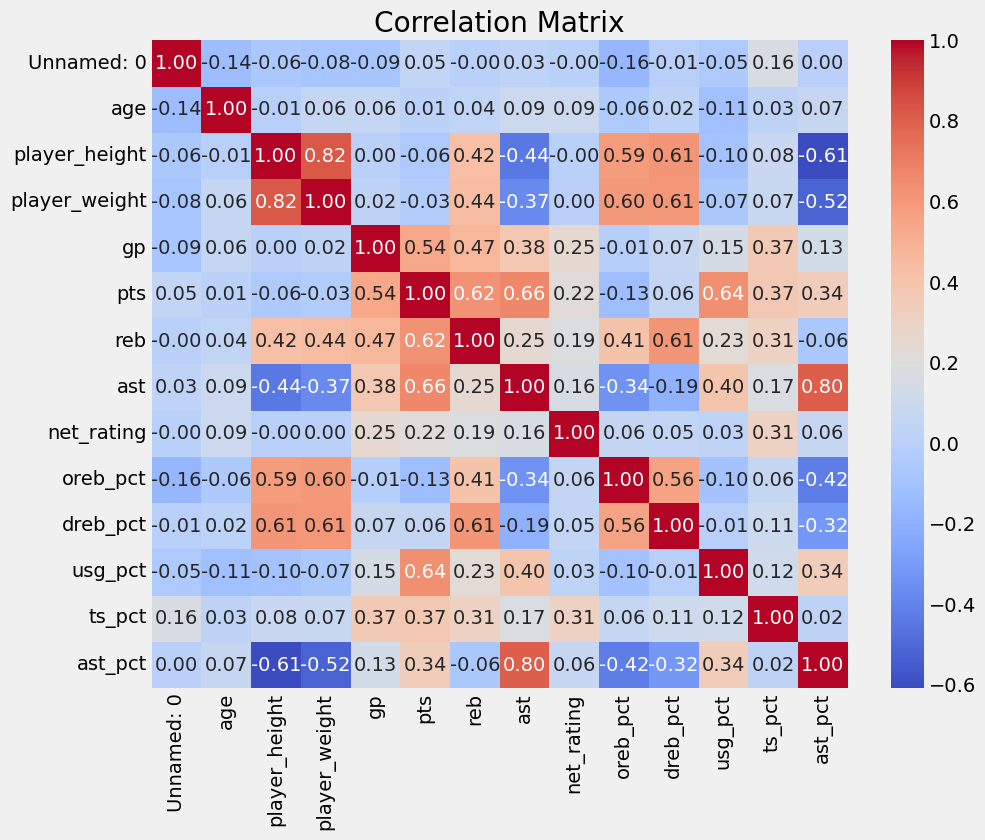

In [31]:
# Correlation Analysis
correlation_matrix = data.corr()  # Replace `data` with your dataset
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


# Linear Regression Modeling

In [34]:
target = 'pts'
X = data.drop(columns=[target])  # Predictor variables
y = data[target]  # Target variable

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [49]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)


In [50]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [55]:
# y_pred = lm.predict(X_test)
print('RMSE of linear regression model is', np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE of linear regression model is 3130191.101999129


# RidgeRegression Model

In [54]:
# Initialize Ridge regression model
lm_Grid = Ridge(random_state=42)

# Define the parameter grid for alpha
params = {
    'alpha': [0.01, 0.1, 1, 10]
}

# Function to perform GridSearchCV and output the best results
def grid_search_cv(regressor, params, X_train, y_train):
    # Create GridSearchCV with negative mean squared error as the scoring metric
    model = GridSearchCV(regressor, params, scoring='neg_mean_squared_error', cv=5)  # cv=5 for 5-fold cross-validation
    model.fit(X_train, y_train)
    
    # Print the best hyperparameters and best RMSE
    print('Best parameters were:', model.best_params_)
    print('Best RMSE was:', np.sqrt(-1 * model.best_score_))

# Run GridSearchCV for Ridge regression with the parameter grid
grid_search_cv(lm_Grid, params, X_train, y_train)


Best parameters were: {'alpha': 1}
Best RMSE was: 1.764022168252162


# Summary:
Linear Regression:

RMSE = 3,130,191.1, which indicates poor model performance and high prediction error.


Ridge Regression:

Best parameter: alpha = 1, which controls regularization.
Best RMSE = 1.764, showing a significant improvement in prediction accuracy compared to linear regression.

Ridge Regression adds regularization (penalty to large coefficients), which helps reduce overfitting, leading to a better generalization on new data and lower error (RMSE)

# Report:

The selected features—age, height, weight, games played, usage percentage, and true shooting percentage—each contribute uniquely to predicting player performance. By analyzing the coefficients, we can determine the relative importance of each feature and how it influences the prediction of player success.

we built a predictive model to estimate future performance, focusing on cumulative points for upcoming seasons. Initially, Linear Regression was used, but the results indicated high prediction errors. To improve accuracy, Ridge Regression was applied, incorporating regularization to reduce overfitting and enhance model generalization.